In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:,.0f}'.format

In [3]:
datos = pd.read_csv("dataset\Anuncios_usados.csv")
datos_sinprocesar = datos.copy()

# ESTE NOTEBOOK

Este notebook plantea unos modelos de prediccion de precios de coches de segunda mano teniendo en cuenta diferentes caracteristicas de los coches. Se utilzia el primer modelo planteado. El codigo de los demás modelos está en funciones no se utilizan. En caso de querer utilizar los otros modelos se tendrian que escribir las funciones: decisionTreeRegresion() o multipleLinearRegresion().

Este notebook es para el hackaton organizado por la empresa de fabricante de vehículos Mercedes-Benz en 2022.
Los recursos necesarios para el procesamiento de este notebook están en este mismo directorio.

# Estadisticas generales de los datos

In [4]:
def infoGeneral(df):
    print(f"{df.shape[0]} muestras y "
          f"{df.shape[1]} columnas")

In [5]:
infoGeneral(datos_sinprocesar)

268252 muestras y 23 columnas


In [6]:
datos.head()

,Maker,Genmodel,Genmodel_ID,Adv_ID,Color,Reg_year,Bodytype,Runned_Miles,Engin_size,Gearbox,Fuel_type,Engine_power,Annual_Tax,Wheelbase,Height,Width,Length,Average_mpg,Top_speed,Seat_num,Door_num,Ad_Date,Price_USD
0,Bentley,Arnage,10_1,10_1$$1,Silver,"2,000",Saloon,60000,6.8L,Automatic,Petrol,NaN,NaN,"3,116","1,515","2,125","5,390",NaN,NaN,5,4,April+2018,"29,612"
1,Bentley,Arnage,10_1,10_1$$2,Grey,"2,002",Saloon,44000,6.8L,Automatic,Petrol,450,315,"3,116","1,515","2,125","5,390",13.7 mpg,179 mph,5,4,June2018,"38,196"
2,Bentley,Arnage,10_1,10_1$$3,Blue,"2,002",Saloon,55000,6.8L,Automatic,Petrol,400,315,"3,116","1,515","2,125","5,390",14.7 mpg,155 mph,5,4,November!$2017,"39,418"
3,Bentley,Arnage,10_1,10_1$$4,Green,"2,003",Saloon,14000,6.8L,Automatic,Petrol,NaN,NaN,"3,116","1,515","2,125","5,390",NaN,NaN,5,4,April+@2018,"48,134"
4,Bentley,Arnage,10_1,10_1$$5,Grey,"2,003",Saloon,61652,6.8L,Automatic,Petrol,NaN,NaN,"3,116","1,515","2,125","5,390",NaN,NaN,5,4,November/2017,"34,893"


In [7]:
datos.describe()

,Reg_year,Engine_power,Wheelbase,Height,Width,Length,Seat_num,Door_num,Price_USD
count,"268,245","236,442","240,255","240,452","240,173","240,452","261,778","263,700","252,243"
mean,"2,013",151,"2,565","1,531","1,896","4,371",5,4,"18,955"
std,4,84,490,164,151,423,1,1,"42,674"
min,"1,900",17,0,0,"1,191",0,1,0,130
25%,"2,010",99,"2,511","1,456","1,780","4,081",5,4,"6,259"
50%,"2,014",128,"2,640","1,494","1,884","4,385",5,5,"11,832"
75%,"2,016",175,"2,752","1,624","2,020","4,672",5,5,"21,821"
max,"2,019",740,"5,246","2,660","2,690","6,165",17,7,"12,791,457"


In [8]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268252 entries, 0 to 268251
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Maker         268252 non-null  object 
 1    Genmodel     268252 non-null  object 
 2    Genmodel_ID  268252 non-null  object 
 3   Adv_ID        268252 non-null  object 
 4   Color         246377 non-null  object 
 5   Reg_year      268245 non-null  float64
 6   Bodytype      267298 non-null  object 
 7   Runned_Miles  267197 non-null  object 
 8   Engin_size    266188 non-null  object 
 9   Gearbox       268085 non-null  object 
 10  Fuel_type     267843 non-null  object 
 11  Engine_power  236442 non-null  float64
 12  Annual_Tax    221579 non-null  object 
 13  Wheelbase     240255 non-null  float64
 14  Height        240452 non-null  float64
 15  Width         240173 non-null  float64
 16  Length        240452 non-null  float64
 17  Average_mpg   226320 non-null  object 
 18  Top_

# Limpieza de datos

## Fechas (tiene que ir antes de General)

Vamos a separar la columna Ad_Date en dos columnas diferentes utilizando regex.

In [9]:
datos['Month'] = datos['Ad_Date'].str.extract(r'([A-Z]+[a-z]*).*(\d{4})')[0]
datos['Year'] = datos['Ad_Date'].str.extract(r'([A-Z]+[a-z]*).*(\d{4})')[1]

## Caracteres especiales

La columna Annual_Tax deberia de ser numerica pero vemos que tiene el caracter *. Se va a borrar este caracter de todas las celdas de esta columna. Para hacer esto se ha utilizado datos.head() y datos.info(). No se muestran en este notebook ya que ensuciarian el codigo.

In [10]:
def inputeAnnuel_Tax(x):
    if isinstance(x, str):
        return (x.replace('*',''))
    return x

datos['Annual_Tax'].map(inputeAnnuel_Tax)

0          NaN
1          315
2          315
3          NaN
4          NaN
          ... 
268247     NaN
268248     NaN
268249     NaN
268250     NaN
268251     NaN
Name: Annual_Tax, Length: 268252, dtype: object

## Replaces

Quitamos los textos en las columnas que deben de ser de tipo int. Antes de hacer esto se observan los datos y los tipos de dato de cada columna. Para esto se puede utilizar un datos.info() y contrastar los resultados.

In [11]:
datos['Top_speed'] = datos['Top_speed'].str.replace(' mph','')
datos['Average_mpg'] = datos['Average_mpg'].str.replace(' mpg','')
datos['Engin_size'] = datos['Engin_size'].str.replace('L','')

Hay algunas celdas que tienen algunos caracteres que no son numeros cuando deberian de serlo. Para esas celdas hemos hecho lo siguiente. Las convertiremos a null y despues se procesarán. 
Antes de hacer esto veremos cuantos valores nulos hay en cada columna.

In [12]:
datos.isnull().sum()

Maker               0
 Genmodel           0
 Genmodel_ID        0
Adv_ID              0
Color           21875
Reg_year            7
Bodytype          954
Runned_Miles     1055
Engin_size       2064
Gearbox           167
Fuel_type         409
Engine_power    31810
Annual_Tax      46673
Wheelbase       27997
Height          27800
Width           28079
Length          27800
Average_mpg     41932
Top_speed       43601
Seat_num         6474
Door_num         4552
Ad_Date             0
Price_USD       16009
Month               0
Year                0
dtype: int64

In [13]:
datos['Runned_Miles'] = pd.to_numeric(datos['Runned_Miles'], errors='coerce')
datos['Engin_size'] = pd.to_numeric(datos['Engin_size'], errors='coerce')
datos['Annual_Tax'] = pd.to_numeric(datos['Annual_Tax'], errors='coerce')
datos['Average_mpg'] = pd.to_numeric(datos['Average_mpg'], errors='coerce')
datos['Top_speed'] = pd.to_numeric(datos['Top_speed'], errors='coerce')
datos['Year'] = pd.to_numeric(datos['Year'], errors='coerce') #tiene que ir después de #Fechas

El nombre de la columna tiene un espacio de más por lo que,

In [14]:
datos.rename(columns={' Genmodel_ID':'Genmodel_ID'},
               inplace=True)

Como la hemos separado anteriormente en dos columnas diferentes se elimina.

In [15]:
datos = datos.drop(columns=['Ad_Date'], axis=1)

Vamos los datos que tenemos en null. Como se ve en Runned_Miles, ahora tenemos mas nulos que anteriormente ya que hemos convertido a nulo las celdas que no eran numeros.

In [16]:
datos.isnull().sum()

Maker               0
 Genmodel           0
Genmodel_ID         0
Adv_ID              0
Color           21875
Reg_year            7
Bodytype          954
Runned_Miles     1313
Engin_size       2064
Gearbox           167
Fuel_type         409
Engine_power    31810
Annual_Tax      81510
Wheelbase       27997
Height          27800
Width           28079
Length          27800
Average_mpg     41932
Top_speed       43601
Seat_num         6474
Door_num         4552
Price_USD       16009
Month               0
Year                0
dtype: int64

## Quitar nulos

Ahora vamos a tratar los valores nulos.

In [17]:
datos = datos.replace('?',np.NaN)
datos.isnull().sum()

Maker               0
 Genmodel           0
Genmodel_ID         0
Adv_ID              0
Color           21875
Reg_year            7
Bodytype          954
Runned_Miles     1313
Engin_size       2064
Gearbox           167
Fuel_type         409
Engine_power    31810
Annual_Tax      81510
Wheelbase       27997
Height          27800
Width           28079
Length          27800
Average_mpg     41932
Top_speed       43601
Seat_num         6474
Door_num         4552
Price_USD       16009
Month               0
Year                0
dtype: int64

Se muestran las columnas numericas y la cantidad de valores nulos de cada una.

In [18]:
selectorNumericos = selector(dtype_include=np.number)
numericas = selectorNumericos(datos)
datos[numericas].isnull().sum()

Reg_year            7
Runned_Miles     1313
Engin_size       2064
Engine_power    31810
Annual_Tax      81510
Wheelbase       27997
Height          27800
Width           28079
Length          27800
Average_mpg     41932
Top_speed       43601
Seat_num         6474
Door_num         4552
Price_USD       16009
Year                0
dtype: int64

Vamos a utilizar la media de las celdas de esa misma columna para rellenar las celdas que tengan valores nulos.

In [19]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

for n in numericas:
    datos[n] = imputer.fit_transform(datos[[n]])

Vamos a hacer lo mismo que anteriormente, pero en esta ocasion con tipos de dato object. Estas celdas se rellenarán con los valores que mas se repitan en su respectiva columna.

In [20]:
selectorCategoricos = selector(dtype_include=object)
categoricas = selectorCategoricos(datos)

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

for c in categoricas:
    datos[c] = imputer.fit_transform(datos[[c]])

Ninguna celda tiene un valor nulo.

In [21]:
datos.isnull().sum()

Maker           0
 Genmodel       0
Genmodel_ID     0
Adv_ID          0
Color           0
Reg_year        0
Bodytype        0
Runned_Miles    0
Engin_size      0
Gearbox         0
Fuel_type       0
Engine_power    0
Annual_Tax      0
Wheelbase       0
Height          0
Width           0
Length          0
Average_mpg     0
Top_speed       0
Seat_num        0
Door_num        0
Price_USD       0
Month           0
Year            0
dtype: int64

# Datos procesados para BRIAN

Para el uso de visualizacion de datos y el manejo de datos en crudo se va a generar un documento .csv con los datos limpios.
Esto lo hacemos antes de utilizar el EncoderLabel ya que eso haría que los datos no se pudieran entender.

In [22]:
datos_limpios = datos.copy()

#### Creacion de CSV en exterior [ESCRIBIR DIRECTORIO ENTRE LAS COMILLAS, SI NO, ESTARÁ EN EL DIRECTORIO DE ESTE NOTEBOOK]

In [23]:
directorio = '' #C:\Users\
nombre_archivo = 'anuncios_limpios.csv'

In [24]:
datos.to_csv(directorio+nombre_archivo, index=False)

# Visualizar datos

Ahora se van a visualizar algunos datos para ver relaciones ente columnas. 
También para datos de interés.

#### Datos TOP_SPEED

Vamos a ver de forma grafica la cantidad de coches que se venden de segunda mano, ralacionando esta cantidad con la velocidad maxima del coche.

In [25]:
datos['Top_speed'].describe()

count   268,252
mean        122
std          17
min          11
25%         112
50%         122
75%         129
max         226
Name: Top_speed, dtype: float64

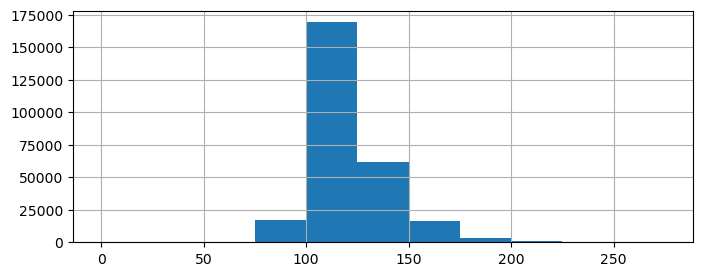

In [26]:
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275]
_ = datos['Top_speed'].hist(figsize=(8, 3), bins=bins)

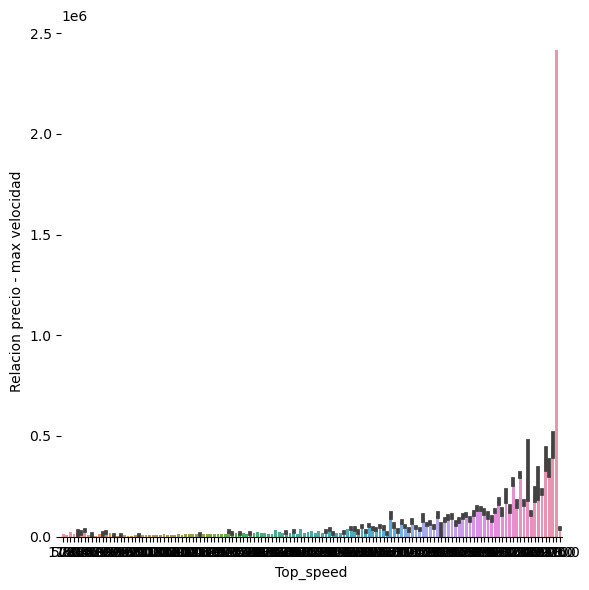

In [27]:
g = sns.catplot(x="Top_speed", y="Price_USD", data=datos, kind='bar', height = 6)
g.despine(left = True)
g.set_ylabels("Relacion precio - max velocidad")

# Creacion de modelo

Ahora se va a crear el modelo de prediccion para el precio.
Antes de eso vamos a cambiar los valores categoricos. Vamos a darles un valor numerico para que sean mas faciles de procesar.

## Encoder & Normalizacion y Estandarizacion

### Encoder

Tomamos todos los valores de tipo object pero quitamos las columnas de ID ya que no vamos a utilizarlas para la prediccion

In [28]:
selectorCategoricos = selector(dtype_include=object)
categoricas = selectorCategoricos(datos)
categoricas.remove('Genmodel_ID')
categoricas.remove('Adv_ID')
encoder = LabelEncoder()
for c in categoricas:
    datos[c] = encoder.fit_transform(datos[c])
datos.head()

,Maker,Genmodel,Genmodel_ID,Adv_ID,Color,Reg_year,Bodytype,Runned_Miles,Engin_size,Gearbox,Fuel_type,Engine_power,Annual_Tax,Wheelbase,Height,Width,Length,Average_mpg,Top_speed,Seat_num,Door_num,Price_USD,Month,Year
0,5,153,10_1,10_1$$1,18,"2,000",15,"60,000",7,0,9,151,159,"3,116","1,515","2,125","5,390",51,122,5,4,"29,612",0,"2,018"
1,5,153,10_1,10_1$$2,8,"2,002",15,"44,000",7,0,9,450,315,"3,116","1,515","2,125","5,390",14,179,5,4,"38,196",6,"2,018"
2,5,153,10_1,10_1$$3,2,"2,002",15,"55,000",7,0,9,400,315,"3,116","1,515","2,125","5,390",15,155,5,4,"39,418",9,"2,017"
3,5,153,10_1,10_1$$4,7,"2,003",15,"14,000",7,0,9,151,159,"3,116","1,515","2,125","5,390",51,122,5,4,"48,134",0,"2,018"
4,5,153,10_1,10_1$$5,8,"2,003",15,"61,652",7,0,9,151,159,"3,116","1,515","2,125","5,390",51,122,5,4,"34,893",9,"2,017"


In [29]:
datos['Gearbox'].value_counts() #está bien

1    170998
0     97117
2       137
Name: Gearbox, dtype: int64

Podriamos tambien hacerlo con los numericos pero da peores resultados.

In [30]:
'''
selectorNumericos = selector(dtype_include=np.number)
numericas = selectorNumericos(datos)
encoder = LabelEncoder()
for c in categoricas:
    datos[c] = encoder.fit_transform(datos[c])
'''

'\nselectorNumericos = selector(dtype_include=np.number)\nnumericas = selectorNumericos(datos)\nencoder = LabelEncoder()\nfor c in categoricas:\n    datos[c] = encoder.fit_transform(datos[c])\n'

In [31]:
datos['Door_num'].value_counts()

5    177541
3     32956
4     29568
2     23464
4      4552
6       169
7         1
0         1
Name: Door_num, dtype: int64

### Normalizacion y estandarizacion

No se van a cambiar los datos

## Guardado de datos

Se guardan los datos para utilizarlos en diferentes notebooks.

In [32]:
datos.to_csv('anuncios_antes_de_modelo.csv', index=False)

## Prueba con testeo a mano

Se crea la funcion de un test rapido para probar.

In [33]:
def testManual(regressor):
    x_test = pd.DataFrame(columns=('Maker', ' Genmodel', 'Color', 'Reg_year', 'Bodytype', 'Runned_Miles',
       'Engin_size', 'Gearbox', 'Fuel_type', 'Engine_power', 'Annual_Tax',
       'Wheelbase', 'Height', 'Width', 'Length', 'Average_mpg', 'Top_speed',
       'Seat_num', 'Door_num', 'Month', 'Year'))
    x_test.loc[0] = (1,1,2,2012,4,100000,1,1,2,140,140,1,255,45,45,102,205,2,4,2,5)

    precio_estimado = regressor.predict(x_test)

    print('Precio estimado: '+ str(precio_estimado))

## Random Forest Regression

Se va a utilizar Random Forest Regressio para crear un modelo

De todos los datos que tenemos en el dataframe datos vamos a coger los datos que no sean del año 2021

In [34]:
X = datos[datos['Year'] != 2021]

De esos datos, vamos a eliminar la columna que vamos a predecir, y otras columnas que no queremos que el modelo aprenda

In [35]:
X = datos.drop(columns=['Price_USD', 'Genmodel_ID', 'Adv_ID'], axis=1)
y = datos['Price_USD'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

Entrenamos el modelo, esto suele llevar 5 minutos aproximadamente.

In [36]:
%%time

regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train, y_train)

Wall time: 20.9 s


RandomForestRegressor(n_estimators=10, random_state=0)

Haces predicciones de los resultados.

In [37]:
y_pred = regressor.predict(X_test)
Y_train_pred = regressor.predict(X_train)
np.set_printoptions(precision=2)

In [38]:
print('Metricas de prediccion de test')
print('R2 Test: '+str(r2_score(y_test,y_pred)))
print('rmse Test: '+str(mean_squared_error(y_test,y_pred,squared=False)))
print('')

print('Metricas de prediccion de training')
print('R2 Train: '+str(r2_score(y_train,Y_train_pred)))
print('rmse Train: '+str(mean_squared_error(y_train,Y_train_pred,squared=False)))

Metricas de prediccion de test
R2 Test: 0.500479225707661
rmse Test: 22185.622439605533

Metricas de prediccion de training
R2 Train: 0.8456353578231146
rmse Train: 17370.75977877877


Vamos a ver con el test manual que precio nos indica.

In [39]:
testManual(regressor)

Precio estimado: [573327.35]


El resultado final es que con los datos de entrenamiento R2 es de 0.84 lo cual no es un valor muy alto pero está bastante bien.
El R2 del test si que es un poco bajo, 0.50. Es un resultado más bajo de lo que se podría esperar.

## Decision Tree Regression

En este modelo se ve que el modelo se ha entrenado mal y ha sido overfiteado ya que el R2 del training es 0.99.

Se procede a hacer el mismo procedimiento que el anterior pero se cambia el tipo de regresion que queremos utilizar.

#### Overfiteado

In [40]:
def decisionTreeRegresion():
    X = datos.drop(columns=['Price_USD', 'Genmodel_ID', 'Adv_ID'], axis=1)
    y = datos['Price_USD'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

    regressor = DecisionTreeRegressor(random_state = 0)
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    Y_train_pred = regressor.predict(X_train)
    np.set_printoptions(precision=2)

    print('Metricas de prediccion de test')
    print('R2 Test: '+str(r2_score(y_test,y_pred)))
    print('rmse Test: '+str(mean_squared_error(y_test,y_pred,squared=False)))
    print('')
    print('Metricas de prediccion de training')
    print('R2 Train: '+str(r2_score(y_train,Y_train_pred)))
    print('rmse Train: '+str(mean_squared_error(y_train,Y_train_pred,squared=False)))

## Multiple Linear Regression

En este modelo de prediccion tenemos resultado muy malos. Tenemos peores resultados en el training que en el testing.

In [41]:
def multipleLinearRegresion():
    X = datos.drop(columns=['Price_USD', 'Genmodel_ID', 'Adv_ID'], axis=1)
    y = datos['Price_USD'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

    regressor = LinearRegression()
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    Y_train_pred = regressor.predict(X_train)
    np.set_printoptions(precision=2)

    print('Metricas de prediccion de test')
    print('R2 Test: '+str(r2_score(y_test,y_pred)))
    print('rmse Test: '+str(mean_squared_error(y_test,y_pred,squared=False)))
    print('')
    print('Metricas de prediccion de training')
    print('R2 Train: '+str(r2_score(y_train,Y_train_pred)))
    print('rmse Train: '+str(mean_squared_error(y_train,Y_train_pred,squared=False)))

## Random Forest Regression 1 top speed y precio

Se quería hacer un modelo que predijera el precio al que se venderia el coche de segunda mano dependiendo de su velocidad maxima. Así se podría saber si realmente merece la pena esforzarse en aumentar la velocidad punta de los vehiculos cara a la venta de segunda mano.
Es un modelo que todavía para implementar.

In [42]:
'''
X_grid = np.arange(min(X['Top_speed']), max(X['Top_speed']), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X['Top_speed'], y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (Random Forest Regression)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()
'''

"\nX_grid = np.arange(min(X['Top_speed']), max(X['Top_speed']), 0.01)\nX_grid = X_grid.reshape((len(X_grid), 1))\nplt.scatter(X['Top_speed'], y, color = 'red')\nplt.plot(X_grid, regressor.predict(X_grid), color = 'blue')\nplt.title('Truth or Bluff (Random Forest Regression)')\nplt.xlabel('Position level')\nplt.ylabel('Salary')\nplt.show()\n"

# Scoring

Aqui se procesan los datos y con regressor se hace un prediccion.
Se tienen en cuenta los requisitos de entrega del hackaton.


#### Requisitos

Nombre del archivo : "XX-talenthighway-prediction.csv"

Consideraciones :
1. Debe ser guardado en formato .csv
2. Debe contener dos columnas ordenadas de la siguiente manera; por filas ['adv_id', 'price'], por columnas de manera ascendente por 'adv_id'.
3. Debe incluir el header.
4. La columna 'adv_id' debe estar en formato string y la columna 'price' en formato float.
5. Debe tener un tamaño de 14864 filas (14865 contando el header).
6. Debe tener todos los valores llenos (no nulos) y cada uno debe ser único (sin duplicados)

#### Tener en cuenta el modelo(regressor) que se está utilizando

In [43]:
scoring = datos[datos['Year'] == 2021]

In [44]:
pred = regressor.predict(scoring.drop(columns=['Price_USD', 'Genmodel_ID', 'Adv_ID'], axis=1))

In [45]:
scoring = scoring[['Adv_ID']]

In [46]:
scoring['price'] = pred

In [47]:
scoring.rename(columns={'Adv_ID':'adv_id'},
               inplace=True)

In [48]:
scoring.head()

,adv_id,price
162,10_3$$132,"18,955"
163,10_3$$133,"18,955"
164,10_3$$134,"18,955"
165,10_3$$135,"18,955"
166,10_3$$136,"18,955"


In [49]:
scoring.to_csv('GAMMA-talenthighway-prediction.csv', index=False)

In [50]:
scoring.price.value_counts()

18,955    3446
18,955    1749
18,955    1267
18,955     829
18,955     812
          ... 
23,185       1
49,193       1
18,979       1
20,153       1
19,290       1
Name: price, Length: 185, dtype: int64

In [51]:
scoring.shape

(14864, 2)